In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import data, img_as_float
from skimage.segmentation import chan_vese
from PIL import Image
from scipy.ndimage import distance_transform_edt as distance

# Pure Chan Vese

In [2]:
im = Image.open('/content/drive/MyDrive/dev/julia/ActiveContours/images/cameraman.tif')
image = np.array(im)

In [3]:
# image = img_as_float(data.camera())
# Feel free to play around with the parameters to see how they impact the result
cv = chan_vese(image, mu=0.25, lambda1=1, lambda2=1, tol=1e-3,
               max_iter=200, dt=0.5, init_level_set="checkerboard",
               extended_output=True)

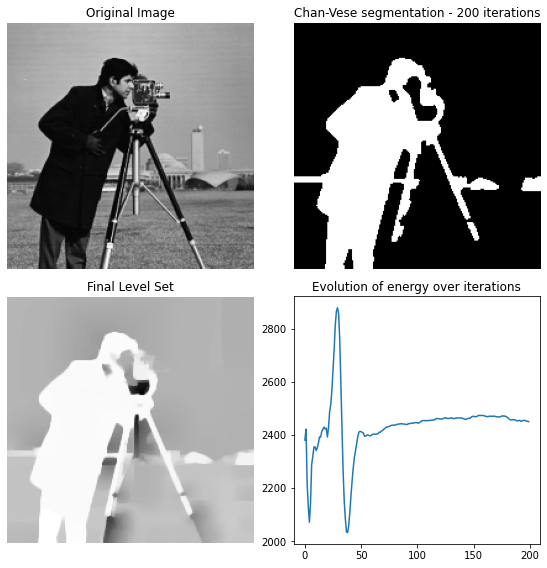

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = f'Chan-Vese segmentation - {len(cv[2])} iterations'
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(cv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()

# Step by Step

## Functions

In [67]:
def _cv_curvature(phi):
    """Returns the 'curvature' of a level set 'phi'.
    """
    P = np.pad(phi, 1, mode='edge')
    fy = (P[2:, 1:-1] - P[:-2, 1:-1]) / 2.0
    fx = (P[1:-1, 2:] - P[1:-1, :-2]) / 2.0
    fyy = P[2:, 1:-1] + P[:-2, 1:-1] - 2*phi
    fxx = P[1:-1, 2:] + P[1:-1, :-2] - 2*phi
    fxy = .25 * (P[2:, 2:] + P[:-2, :-2] - P[:-2, 2:] - P[2:, :-2])
    grad2 = fx**2 + fy**2
    K_num = (fxx*fy**2 - 2*fxy*fx*fy + fyy*fx**2)
    K_den = (grad2*np.sqrt(grad2) + 1e-8)
    K = K_num / K_den
    return K

In [71]:
test_phi = np.array([
    [10, -100, 10, 190, 20],
    [10, -100, 10, -100, 20],
    [10, -100, 10, -100, 20],
    [10, -100, 10, -100, 20],
    [10, -100, -100, -100, 20],
])

In [72]:
_cv_curvature(test_phi)

array([[ 0.        ,  0.        ,  0.        , -2.41186816,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.58575584,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -4.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [11]:
def _cv_calculate_averages(image, Hphi):
    """Returns the average values 'inside' and 'outside'.
    """
    H = Hphi
    Hinv = 1. - H
    Hsum = np.sum(H)
    Hinvsum = np.sum(Hinv)
    avg_inside = np.sum(image * H)
    avg_oustide = np.sum(image * Hinv)
    if Hsum != 0:
        avg_inside /= Hsum
    if Hinvsum != 0:
        avg_oustide /= Hinvsum
    return (avg_inside, avg_oustide)

In [77]:
test_Hphi = 1 * (test_phi > 0)

In [78]:
test_image = np.array([
    [10, 100, -10, 0, 10],
    [10, 100, -10, 0, 10],
    [10, 100, -10, 0, 10],
    [10, 100, -10, 0, 10],
    [10, 100, -10, 0, 10],
])

In [79]:
_cv_calculate_averages(test_image, test_Hphi)

(4.0, 49.0)

In [10]:
def _cv_delta(x, eps=1.):
    """Returns the result of a regularised dirac function of the
    input value(s).
    """
    return eps / (eps**2 + x**2)

In [80]:
_cv_delta(test_phi)

array([[9.90099010e-03, 9.99900010e-05, 9.90099010e-03, 2.77000637e-05,
        2.49376559e-03],
       [9.90099010e-03, 9.99900010e-05, 9.90099010e-03, 9.99900010e-05,
        2.49376559e-03],
       [9.90099010e-03, 9.99900010e-05, 9.90099010e-03, 9.99900010e-05,
        2.49376559e-03],
       [9.90099010e-03, 9.99900010e-05, 9.90099010e-03, 9.99900010e-05,
        2.49376559e-03],
       [9.90099010e-03, 9.99900010e-05, 9.99900010e-05, 9.99900010e-05,
        2.49376559e-03]])

In [81]:
test_mu = 0.25
test_lambda1 = 1
test_lambda2 = 1
test_dt = 0.5

In [108]:
def _cv_calculate_variation(image, phi, mu, lambda1, lambda2, dt):
    """Returns the variation of level set 'phi' based on algorithm parameters.
    """
    eta = 1e-16
    P = np.pad(phi, 1, mode='edge')

    phixp = P[1:-1, 2:] - P[1:-1, 1:-1]
    phixn = P[1:-1, 1:-1] - P[1:-1, :-2]
    phix0 = (P[1:-1, 2:] - P[1:-1, :-2]) / 2.0

    phiyp = P[2:, 1:-1] - P[1:-1, 1:-1]
    phiyn = P[1:-1, 1:-1] - P[:-2, 1:-1]
    phiy0 = (P[2:, 1:-1] - P[:-2, 1:-1]) / 2.0

    C1 = 1. / np.sqrt(eta + phixp**2 + phiy0**2)
    C2 = 1. / np.sqrt(eta + phixn**2 + phiy0**2)
    C3 = 1. / np.sqrt(eta + phix0**2 + phiyp**2)
    C4 = 1. / np.sqrt(eta + phix0**2 + phiyn**2)

    K = (P[1:-1, 2:] * C1 + P[1:-1, :-2] * C2 + P[2:, 1:-1] * C3 + P[:-2, 1:-1] * C4)

    Hphi = 1 * (phi > 0)
    (c1, c2) = _cv_calculate_averages(image, Hphi)

    difference_from_average_term = (- lambda1 * (image-c1)**2 +
                                    lambda2 * (image-c2)**2)
    new_phi = (phi + (dt*_cv_delta(phi)) *
               (mu*K + difference_from_average_term))
    return new_phi / (1 + mu * dt * _cv_delta(phi) * (C1+C2+C3+C4))

In [109]:
_cv_calculate_variation(test_image, test_phi, test_mu, test_lambda1, test_lambda2, test_dt)

array([[  10.00005939, -100.00013224,   26.26180386,  190.03302351,
          20.00005941],
       [  10.00005939, -100.00013224,   10.00006569,  -99.88073422,
          20.00005939],
       [  10.00005939, -100.00013224,   10.00006569,  -99.88073755,
          20.00005939],
       [  10.00005939, -100.00013224,   10.00013137,  -99.88073755,
          20.00005939],
       [  10.00005939, -100.00026438,  -99.9998687 ,  -99.99990467,
          20.00005939]])

In [9]:
def _cv_heavyside(x, eps=1.):
    """Returns the result of a regularised heavyside function of the
    input value(s).
    """
    return 0.5 * (1. + (2./np.pi) * np.arctan(x/eps))

In [110]:
 _cv_heavyside(test_phi)

array([[0.96827448, 0.00318299, 0.96827448, 0.9983247 , 0.98409775],
       [0.96827448, 0.00318299, 0.96827448, 0.00318299, 0.98409775],
       [0.96827448, 0.00318299, 0.96827448, 0.00318299, 0.98409775],
       [0.96827448, 0.00318299, 0.96827448, 0.00318299, 0.98409775],
       [0.96827448, 0.00318299, 0.00318299, 0.00318299, 0.98409775]])

In [12]:
def _cv_difference_from_average_term(image, Hphi, lambda_pos, lambda_neg):
    """Returns the 'energy' contribution due to the difference from
    the average value within a region at each point.
    """
    (c1, c2) = _cv_calculate_averages(image, Hphi)
    Hinv = 1. - Hphi
    return (lambda_pos * (image-c1)**2 * Hphi +
            lambda_neg * (image-c2)**2 * Hinv)

In [111]:
_cv_difference_from_average_term(test_image, test_Hphi, test_lambda1, test_lambda2)

array([[  36., 2601.,  196.,   16.,   36.],
       [  36., 2601.,  196., 2401.,   36.],
       [  36., 2601.,  196., 2401.,   36.],
       [  36., 2601.,  196., 2401.,   36.],
       [  36., 2601., 3481., 2401.,   36.]])

In [13]:
def _cv_edge_length_term(phi, mu):
    """Returns the 'energy' contribution due to the length of the
    edge between regions at each point, multiplied by a factor 'mu'.
    """
    toret = _cv_curvature(phi)
    return mu * toret

In [112]:
_cv_edge_length_term(test_phi, test_mu)

array([[ 0.        ,  0.        ,  0.        , -0.60296704,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.39643896,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [14]:
def _cv_energy(image, phi, mu, lambda1, lambda2):
    """Returns the total 'energy' of the current level set function.
    """
    H = _cv_heavyside(phi)
    avgenergy = _cv_difference_from_average_term(image, H, lambda1, lambda2)
    lenenergy = _cv_edge_length_term(phi, mu)
    return np.sum(avgenergy) + np.sum(lenenergy)

In [113]:
_cv_energy(test_image, test_phi, test_mu, test_lambda1, test_lambda2)

28060.04225100435

In [140]:
def _cv_checkerboard(image_size, square_size):
    """Generates a checkerboard level set function.
    According to Pascal Getreuer, such a level set function has fast
    convergence.
    """
    yv = np.arange(image_size[0]).reshape(image_size[0], 1)
    xv = np.arange(image_size[1])
    yv = yv.astype(np.float64)
    xv = xv.astype(np.float64)
    sf = np.pi / square_size
    xv *= sf
    yv *= sf
    return np.sin(yv) * np.sin(xv)

In [141]:
_cv_checkerboard(image.shape, 5)

array([[ 0.        ,  0.        ,  0.        , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.        ,  0.3454915 ,  0.55901699, ..., -0.55901699,
        -0.55901699, -0.3454915 ],
       [ 0.        ,  0.55901699,  0.9045085 , ..., -0.9045085 ,
        -0.9045085 , -0.55901699],
       ...,
       [-0.        , -0.55901699, -0.9045085 , ...,  0.9045085 ,
         0.9045085 ,  0.55901699],
       [-0.        , -0.55901699, -0.9045085 , ...,  0.9045085 ,
         0.9045085 ,  0.55901699],
       [-0.        , -0.3454915 , -0.55901699, ...,  0.55901699,
         0.55901699,  0.3454915 ]])

In [127]:
img.shape

(200, 1)

## Test

### Load image

In [16]:
im2 = Image.open('/content/drive/MyDrive/dev/julia/ActiveContours/images/blobs.png')
image2 = np.array(im2)

### Initialize level set

In [19]:
# hardcode parameters
mu = 0.25
lambda1 = 1
lambda2 = 1
dt = 0.5
tol=1e-3

In [17]:
phi = _cv_checkerboard(image2.shape, 5.0)

In [18]:
#normalize image
image2 = image2 - np.min(image2)
if np.max(image2) != 0:
    image2 = image2 / np.max(image2)

### Find initial energy

In [20]:
old_energy = _cv_energy(image2, phi, mu, lambda1, lambda2)

### Calculate delta energy

In [21]:
phivar = tol + 1

In [22]:
i = 0
energies = []
max_iter = 200

while(phivar > tol and i < max_iter):
    # Save old level set values
    oldphi = phi

    # Calculate new level set
    phi = _cv_calculate_variation(image2, phi, mu, lambda1, lambda2, dt)
    # phi = _cv_reset_level_set(phi)
    phivar = np.sqrt(((phi-oldphi)**2).mean())

    # Extract energy and compare to previous level set and
    # segmentation to see if continuing is necessary
    segmentation = phi > 0
    new_energy = _cv_energy(image2, phi, mu, lambda1, lambda2)

    # Save old energy values
    energies.append(old_energy)
    old_energy = new_energy
    i += 1

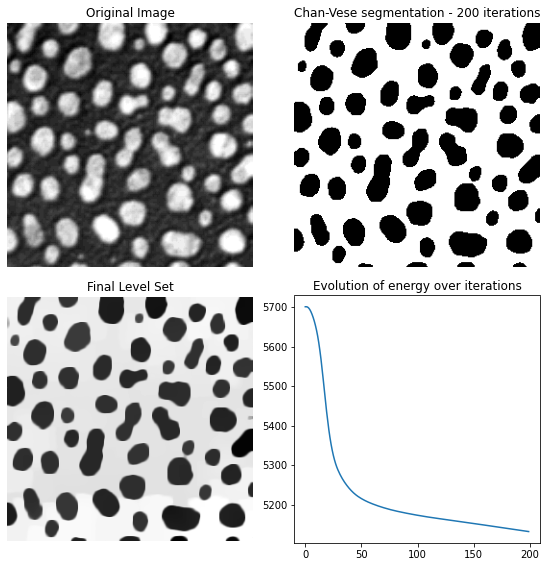

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image2, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(segmentation, cmap="gray")
ax[1].set_axis_off()
title = f'Chan-Vese segmentation - {len(energies)} iterations'
ax[1].set_title(title, fontsize=12)

ax[2].imshow(phi, cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(energies)
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()

# Simplified

In [24]:
def chan_vese2(image, mu=0.25, lambda1=1.0, lambda2=1.0, tol=1e-3, max_iter=500, dt=0.5,):
    
    phi = _cv_checkerboard(image.shape, 5.0)
    image = image - np.min(image)
    if np.max(image) != 0:
        image = image / np.max(image)

    i = 0
    old_energy = _cv_energy(image, phi, mu, lambda1, lambda2)
    energies = []
    phivar = tol + 1
    segmentation = phi > 0

    while(phivar > tol and i < max_iter):
        # Save old level set values
        oldphi = phi

        # Calculate new level set
        phi = _cv_calculate_variation(image, phi, mu, lambda1, lambda2, dt)
        # phi = _cv_reset_level_set(phi)
        phivar = np.sqrt(((phi-oldphi)**2).mean())

        # Extract energy and compare to previous level set and
        # segmentation to see if continuing is necessary
        segmentation = phi > 0
        new_energy = _cv_energy(image, phi, mu, lambda1, lambda2)

        # Save old energy values
        energies.append(old_energy)
        old_energy = new_energy
        i += 1
        
    return (segmentation, phi, energies)

In [25]:
cv2 = chan_vese2(image2, mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_iter=200, dt=0.5)

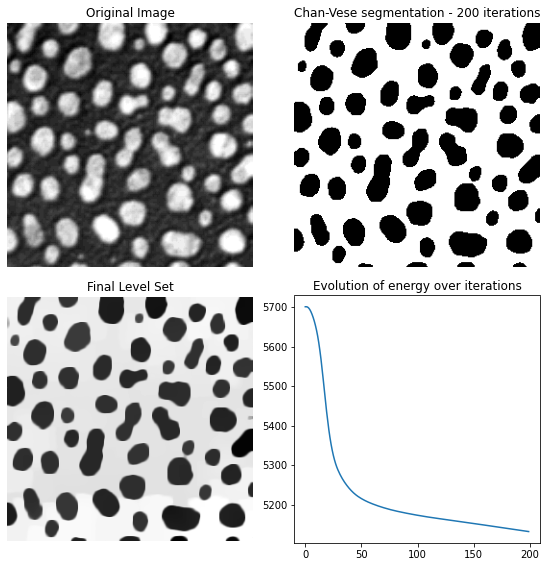

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image2, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv2[0], cmap="gray")
ax[1].set_axis_off()
title = f'Chan-Vese segmentation - {len(cv2[2])} iterations'
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv2[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(cv2[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()